In [15]:
import json
from pathlib import Path
from collections import defaultdict
from typing import List, Dict, Any
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
val_file = "/data/user_data/gdhanuka/STAR_dataset/STAR_val.pkl"
with open(val_file, "rb") as f:
    val_data = pickle.load(f)

# make question_id the key for the val_data
val_data = {q['question_id']: q for q in val_data}

In [13]:
def load_jsonl(file_path: str) -> List[Dict[str, Any]]:
    """Load a JSONL file and return a list of dictionaries."""
    with open(file_path, 'r') as file:
        return [json.loads(line) for line in file]

def calculate_metrics(data: List[Dict[str, Any]]) -> Dict[str, Any]:
    """Calculate key metrics from the data."""
    metrics = {
        "total_questions": len(data),
        "correct_predictions": 0,
        "accuracy": 0.0,
        "category_wise_accuracy": defaultdict(lambda: {"correct": 0, "total": 0}),
        "average_inference_time": 0.0,
        "average_confidence": 0.0
    }
    
    total_confidence = 0.0
    total_inference_time = 0.0
    
    for entry in data:
        category = entry["category"]
        metrics["category_wise_accuracy"][category]["total"] += 1
        total_inference_time += entry["inference_time"]
        total_confidence += max(entry["confidence"])
        
        if entry["pred_ans_idx"] == entry["true_index"]:
            metrics["correct_predictions"] += 1
            metrics["category_wise_accuracy"][category]["correct"] += 1
    
    metrics["accuracy"] = metrics["correct_predictions"] / metrics["total_questions"] if metrics["total_questions"] > 0 else 0.0
    metrics["average_inference_time"] = total_inference_time / metrics["total_questions"] if metrics["total_questions"] > 0 else 0.0
    metrics["average_confidence"] = total_confidence / metrics["total_questions"] if metrics["total_questions"] > 0 else 0.0
    
    # Calculate category-wise accuracy
    for category, values in metrics["category_wise_accuracy"].items():
        total = values["total"]
        correct = values["correct"]
        values["accuracy"] = correct / total if total > 0 else 0.0
    
    return metrics

def analyze_files(file_paths: List[str]) -> Dict[str, Dict[str, Any]]:
    """Analyze multiple JSONL files and return metrics for each."""
    results = {}
    for file_path in file_paths:
        data = load_jsonl(file_path)
        metrics = calculate_metrics(data)
        results[file_path] = metrics
    return results

def display_metrics(metrics: Dict[str, Dict[str, Any]]):
    """Display metrics in a readable format."""
    for file_path, file_metrics in metrics.items():
        print(f"Metrics for file: {file_path}")
        print(f"  Total Questions: {file_metrics['total_questions']}")
        print(f"  Correct Predictions: {file_metrics['correct_predictions']}")
        print(f"  Accuracy: {file_metrics['accuracy']:.2%}")
        print(f"  Average Inference Time: {file_metrics['average_inference_time']:.4f} seconds")
        print(f"  Average Confidence: {file_metrics['average_confidence']:.2%}")
        print("  Category-wise Accuracy:")
        for category, values in file_metrics["category_wise_accuracy"].items():
            print(f"    {category}: {values['accuracy']:.2%} ({values['correct']}/{values['total']})")
        print()

In [2]:
file_paths = ["/home/gdhanuka/STAR_Benchmark/analysis/dummy_results.jsonl"]
metrics = analyze_files(file_paths)
display_metrics(metrics)

Metrics for file: /home/gdhanuka/STAR_Benchmark/analysis/dummy_results.jsonl
  Total Questions: 712
  Correct Predictions: 343
  Accuracy: 48.17%
  Average Inference Time: 0.5437 seconds
  Average Confidence: 35.77%
  Category-wise Accuracy:
    Interaction: 48.17% (343/712)



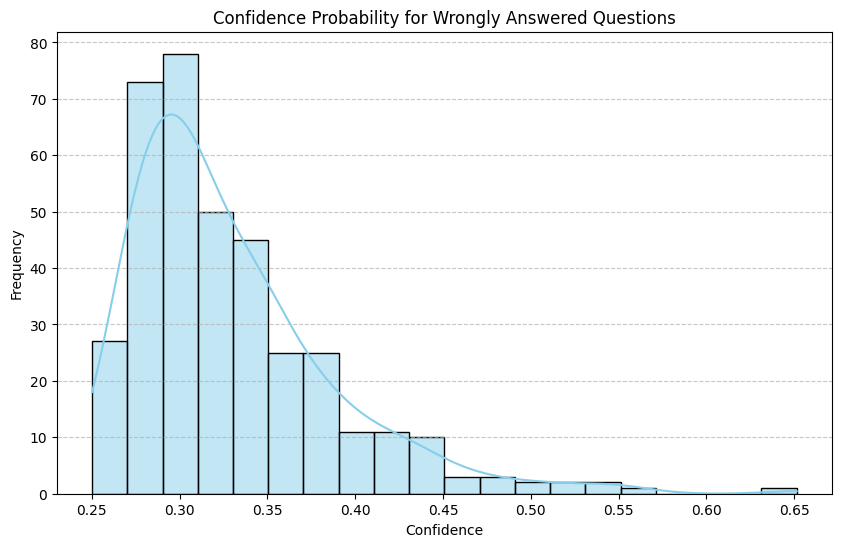

In [ ]:
# Extract confidence probabilities for wrongly answered questions
wrong_confidences = []

for file_path, file_metrics in metrics.items():
    data = load_jsonl(file_path)
    for entry in data:
        if entry["pred_ans_idx"] != entry["true_index"]:
            wrong_confidences.append(max(entry["confidence"]))

# Plot the confidence probabilities
plt.figure(figsize=(10, 6))
sns.histplot(wrong_confidences, bins=20, color='skyblue', edgecolor='black', kde=True)
plt.title('Confidence Probability for Wrongly Answered Questions')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

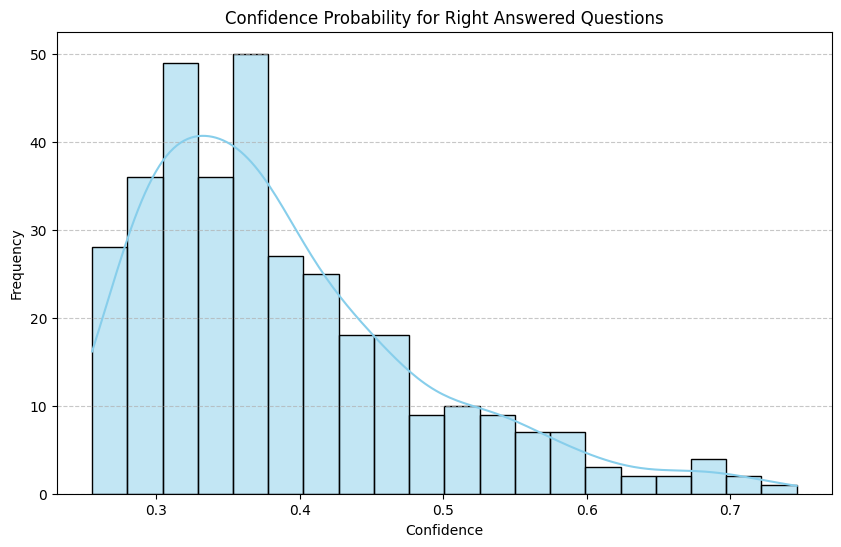

In [21]:
# Extract confidence probabilities for rightly answered questions
right_confidences = []

for file_path, file_metrics in metrics.items():
    data = load_jsonl(file_path)
    for entry in data:
        if entry["pred_ans_idx"] == entry["true_index"]:
            right_confidences.append(max(entry["confidence"]))

# Plot the confidence probabilities
plt.figure(figsize=(10, 6))
sns.histplot(right_confidences, bins=20, color='skyblue', edgecolor='black', kde=True)
plt.title('Confidence Probability for Right Answered Questions')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [11]:
# find number of questions that were random guessing, i.e. difference between highest confidence and lowest confidence is less than guess_threshold (0.1)
guess_threshold = 0.1
random_guessing_right = 0
random_guessing_wrong = 0
for file_path, file_metrics in metrics.items():
    data = load_jsonl(file_path)
    for entry in data:
        if max(entry["confidence"]) - min(entry["confidence"]) < guess_threshold:
            if entry["pred_ans_idx"] == entry["true_index"]:
                random_guessing_right += 1
            else:
                random_guessing_wrong += 1

print(f"Number of questions that were random guessing: {random_guessing_right+random_guessing_wrong} out of {file_metrics['total_questions']}")
print(f"Right random guessing: {random_guessing_right}, Wrong random guessing: {random_guessing_wrong}")

Number of questions that were random guessing: 211 out of 712
Right random guessing: 59, Wrong random guessing: 152


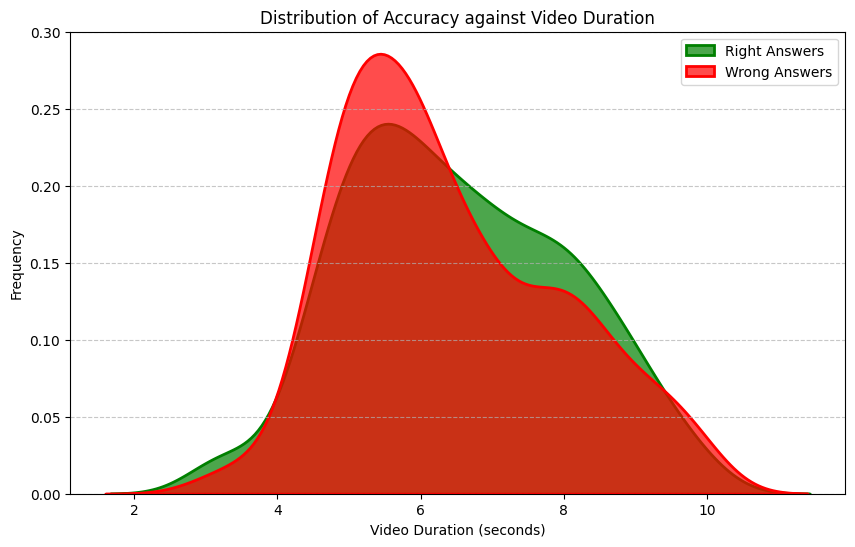

In [26]:
# show the distribution of accuracy against the duration of the video
video_duration_right = []
video_duration_wrong = []

for file_path, file_metrics in metrics.items():
    data = load_jsonl(file_path)
    for entry in data:
        video_duration = val_data[entry["question_id"]]["end"] - val_data[entry["question_id"]]["start"]
        if entry["pred_ans_idx"] == entry["true_index"]:
            video_duration_right.append(video_duration)
        else:
            video_duration_wrong.append(video_duration)

# Plot the distribution
plt.figure(figsize=(10, 6))
# sns.histplot(video_duration_right, bins=20, color='green', edgecolor='black', kde=True, label='Right Answers')
# sns.histplot(video_duration_wrong, bins=20, color='red', edgecolor='black', kde=True, label='Wrong Answers')
sns.kdeplot(video_duration_right, color='green', label='Right Answers', linewidth=2, alpha=0.7, fill=True)
sns.kdeplot(video_duration_wrong, color='red', label='Wrong Answers', linewidth=2, alpha=0.7, fill=True)
plt.title('Distribution of Accuracy against Video Duration')
plt.xlabel('Video Duration (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

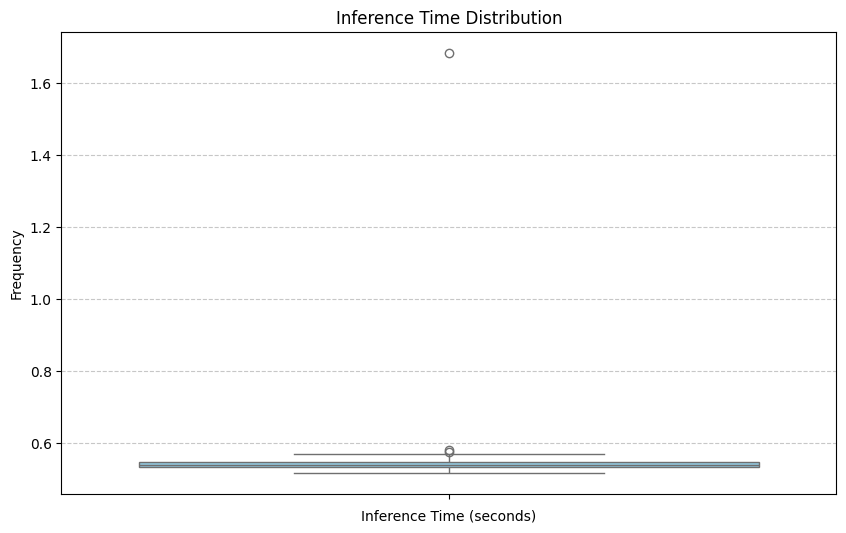

In [30]:
# plot inference time distribution
inference_times = []
for file_path, file_metrics in metrics.items():
    data = load_jsonl(file_path)
    for entry in data:
        inference_times.append(entry["inference_time"])

plt.figure(figsize=(10, 6))
sns.boxplot(inference_times, color='skyblue')
plt.title('Inference Time Distribution')
plt.xlabel('Inference Time (seconds)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()